In [1]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from hmmlearn import hmm

from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np

from modules.data_fetcher import download_historical_data


In [40]:
symbol = "BTC-USDT"  # Best: BNB, BTC,

df_BTC = download_historical_data(symbol, "1hour").loc["2020-11-20":]
df_BTC.dropna(inplace=True)

df_BTC["Returns"] = df_BTC.Close.pct_change()
df_BTC["Log_Returns"] = np.log(df_BTC.Close).pct_change()
df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()

(20742, 9)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Returns
Date,,,,,,,,,
2020-11-20 01:00:00,1.605830e+09,17802.8,17777.1,17932.8,17759.4,50.896954,9.085195e+05,-0.001606,-0.000164
2020-11-20 02:00:00,1.605834e+09,17777.1,17964.4,17966.2,17747.4,51.114373,9.134070e+05,0.010536,0.001071
2020-11-20 03:00:00,1.605838e+09,17960.3,17957.5,18034.8,17920.1,102.944213,1.851233e+06,-0.000384,-0.000039
2020-11-20 04:00:00,1.605841e+09,17957.5,17953.5,18018.7,17938.0,32.661923,5.871090e+05,-0.000223,-0.000023
2020-11-20 05:00:00,1.605845e+09,17955.9,18192.1,18230.7,17943.2,121.304551,2.196964e+06,0.013290,0.001348


In [41]:
model = MarkovRegression(
    df_BTC.Returns, k_regimes=2, trend="c", switching_variance=False, order=2
)
res_kns = model.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                20742
Model:               MarkovRegression   Log Likelihood               71040.579
Date:                Mon, 03 Apr 2023   AIC                        -142071.159
Time:                        09:19:43   BIC                        -142031.459
Sample:                             0   HQIC                       -142058.193
                              - 20742                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.937e-05        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.561e-05        nan        nan        nan         nan         nan
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.204e-05    5.3e-07    116.964      0.000     6.1e-05    6.31e-05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5000        nan        nan        nan         nan         nan
p[1->0]        0.5000        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 5.85e+16. Standard errors may be unstable.
"""

In [42]:
df_BTC["Low_regime_proba"] = tuple(res_kns.smoothed_marginal_probabilities[0])
df_BTC["High_regime_proba"] = tuple(res_kns.smoothed_marginal_probabilities[1])

df_BTC.loc[df_BTC["Low_regime_proba"] < df_BTC["High_regime_proba"], "Regime"] = 1
df_BTC.loc[df_BTC["Low_regime_proba"] > df_BTC["High_regime_proba"], "Regime"] = 2
df_BTC["Regime"] = df_BTC["Regime"].astype(int)

df_BTC.head()


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Returns,Low_regime_proba,High_regime_proba,Regime
Date,,,,,,,,,,,,
2020-11-20 01:00:00,1.605830e+09,17802.8,17777.1,17932.8,17759.4,50.896954,9.085195e+05,-0.001606,-0.000164,0.500171,0.499829,2
2020-11-20 02:00:00,1.605834e+09,17777.1,17964.4,17966.2,17747.4,51.114373,9.134070e+05,0.010536,0.001071,0.498887,0.501113,1
2020-11-20 03:00:00,1.605838e+09,17960.3,17957.5,18034.8,17920.1,102.944213,1.851233e+06,-0.000384,-0.000039,0.500042,0.499958,2
2020-11-20 04:00:00,1.605841e+09,17957.5,17953.5,18018.7,17938.0,32.661923,5.871090e+05,-0.000223,-0.000023,0.500025,0.499975,2
2020-11-20 05:00:00,1.605845e+09,17955.9,18192.1,18230.7,17943.2,121.304551,2.196964e+06,0.013290,0.001348,0.498596,0.501404,1


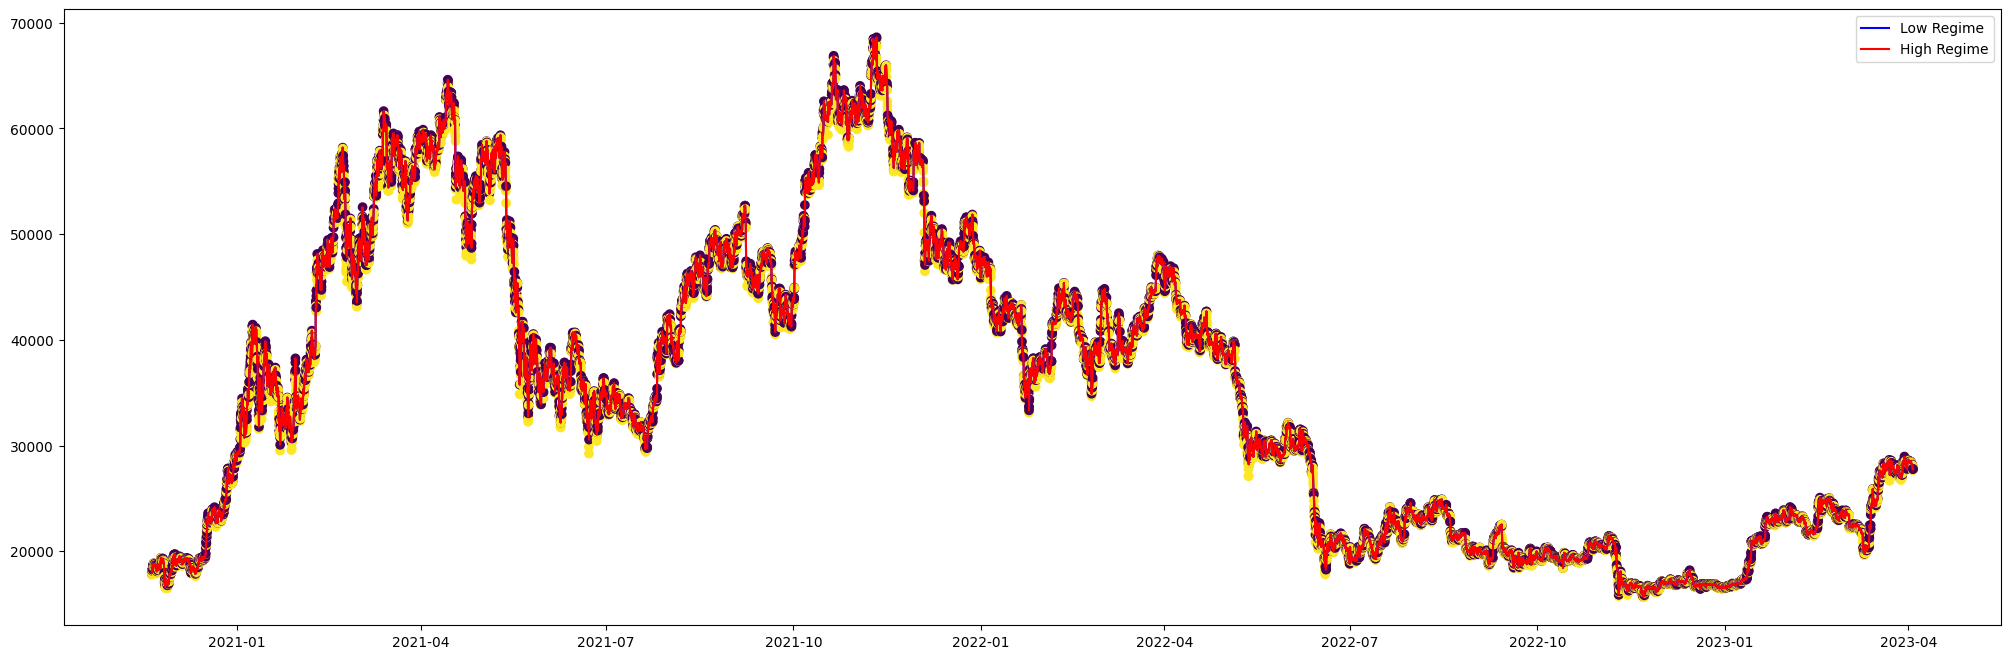

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))

plt.plot(
    df_BTC.loc[df_BTC["Regime"] == 1].index,
    df_BTC.loc[df_BTC["Regime"] == 1]["Close"],
    c="blue",
    label="Low Regime",
)
plt.plot(
    df_BTC.loc[df_BTC["Regime"] == 1].index,
    df_BTC.loc[df_BTC["Regime"] == 1]["Close"],
    c="red",
    label="High Regime",
)
plt.scatter(
    df_BTC.index,
    df_BTC["Close"],
    c=df_BTC.Regime.values,
)
plt.legend()

# With HMM Learn

**hmmlearn** allows us to place certain constraints on the covariance matrices of the multivariate Gaussian distributions.

- `covariance_type = "diag"` — the covariance matrix for each hidden state is a diagonal matrix, and these matrices may be different.
- `covariance_type = "spherical"` — the covariance matrix for each hidden state is proportional to the identity matrix, and these matrices may be different.
- `covariance_type = "full"` — no restrictions placed on the covariance matrices for any of the hidden states.
- `covariance_type = "tied"` — all hidden states share the same full covariance matrix.

<Axes: >

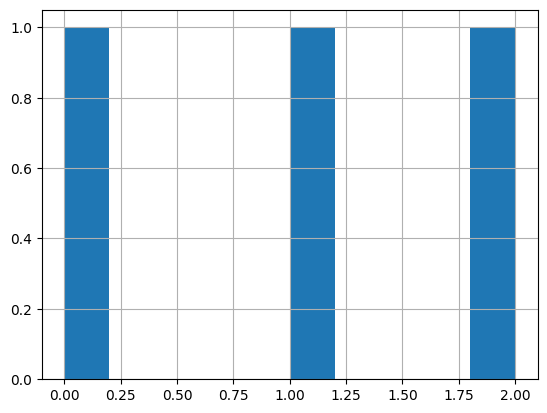

In [44]:

data = df_BTC[["Log_Returns","Volume","Close"]].values#.reshape(-1, 1)
model = hmm.GaussianHMM(n_components=3 ,covariance_type='diag', n_iter = 50, random_state = 42) #covariance_type = "diag"
model.fit(data)
model.score(data)

Z = model.predict(data)
states = pd.unique(Z)

pd.Series(states).hist()

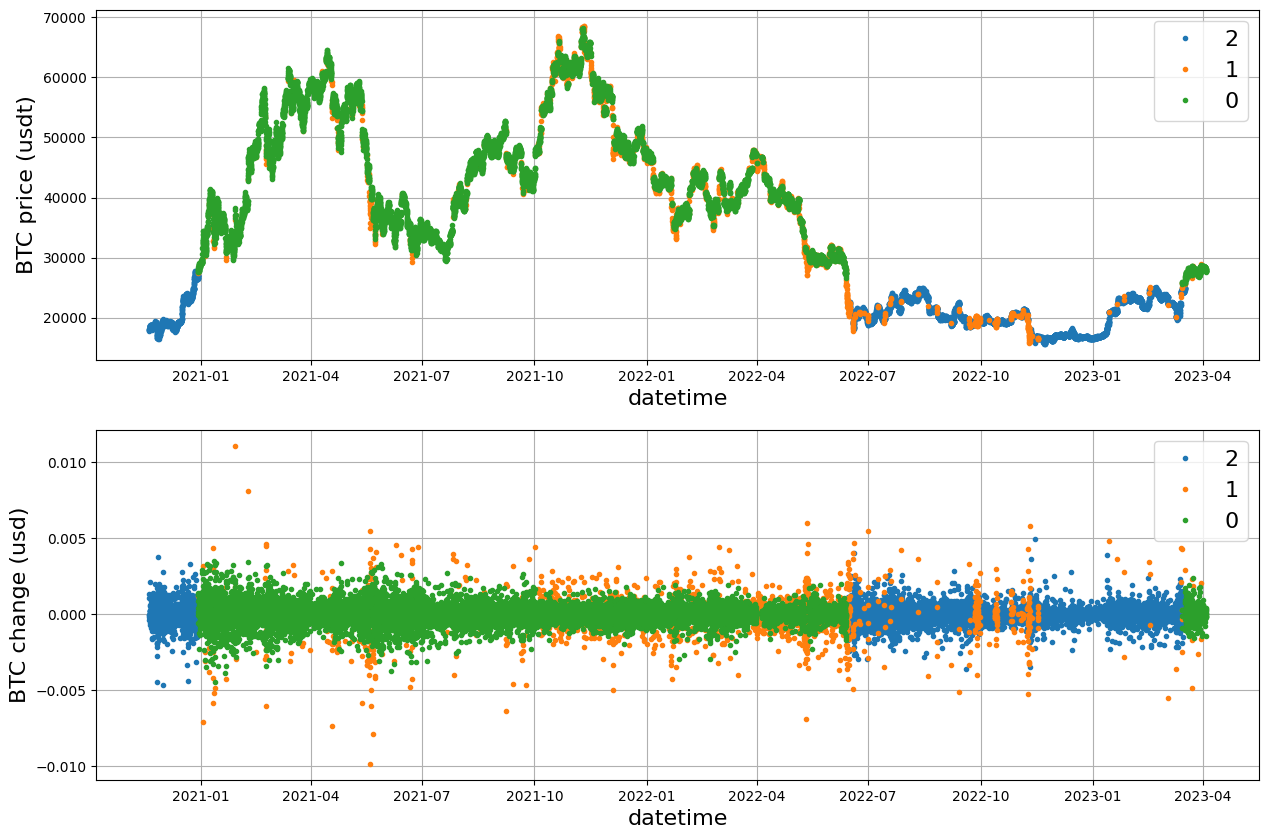

In [45]:
import matplotlib.pyplot as plt 

    # df_BTC.index,
    # df_BTC["Close"],
    # c=df_BTC.Regime.values,

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = df_BTC["Close"].iloc[want].index
    y = df_BTC['Close'].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("BTC price (usdt)", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    x = df_BTC["Log_Returns"].iloc[want].index
    y = df_BTC["Log_Returns"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("BTC change (usd)", fontsize=16)
plt.show()